In [1]:
try:
    # it already installed dependencies
    from torchsummary import summary
    from torchviz import make_dot
except:
    # install graphviz on system
    import platform

    if "Darwin" == platform.system():
        !brew install graphviz
    elif "Linux" == platform.system():
        !sudo apt install graphviz
    else:
        print("go to  https://www.graphviz.org/download/")
    # Next we need to install the following dependencies:
    !pip install torchsummary
    !pip install torch-summary
    !pip install torchviz
    !pip install graphviz
    # import

    from torchsummary import summary
    from torchviz import make_dot

In [2]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
import numpy as np

set_random_seed(12)
set_log_level("ERROR", "INFO")

NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/plotly_resampler/aggregation/aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


Training: 0it [00:00, ?it/s]

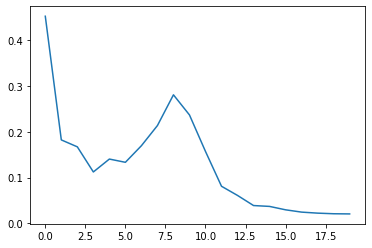

In [8]:
dates = pd.date_range(start="2020-01-01", periods=100, freq="D")
a = [0, 1] * 50
y = -1 * np.array(a[:50])
y = np.concatenate([y, np.array(a[50:])])
# first half: y = -a
# second half: y = a
df = pd.DataFrame({"ds": dates, "y": y, "a": a})

newer_bias = 5
m = NeuralProphet(
    epochs=20,
    batch_size=10,
    learning_rate=1,
    newer_samples_weight=newer_bias,
    newer_samples_start=0.0,
    #     quantiles=[0.1,0.9],
    future_regressors_model="linear",
    #     growth='off',
    n_changepoints=0,
    #     daily_seasonality=False,
    #     weekly_seasonality=False,
    #     yearly_seasonality=False,
)
m.add_future_regressor("a")

metrics_df = m.fit(
    df,
    progress="plot",
)

In [9]:
m.model.future_regressors.regressor_params.additive

Parameter containing:
tensor([[0.2261]], requires_grad=True)

In [ ]:
m.model.tr

In [7]:
m.model.future_regressors.regressor_params.multiplicative

Parameter containing:
tensor([], size=(1, 0), requires_grad=True)

<AxesSubplot:>

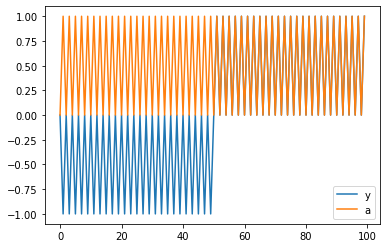

In [85]:
df[["y", "a"]].plot()

In [86]:
import pandas as pd

Predicting: 10it [00:00, ?it/s]

<AxesSubplot:>

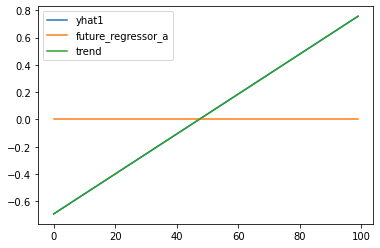

In [87]:
forecast = m.predict(df)

forecast[["yhat1", "future_regressor_a", "trend"]].plot()

In [88]:
fig_param = m.plot_parameters()
display(fig_param)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'type': 'scatter',
              'uid': 'c826226d-435f-4b04-84ec-0199eca1fb53',
              'x': array([datetime.datetime(2020, 1, 1, 0, 0),
                          datetime.datetime(2020, 4, 9, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.6933692,  0.7561643], dtype=float32),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              'name': 'Additive future regressor',
              'type': 'bar',
              'uid': '0843d255-8274-4d67-a8d6-336420cfb0ae',
              'width': 0.8,
              'x': array(['a'], dtype=object),
              'xaxis': 'x2',
              'y': [0.0],
              'yaxis': 'y2'}],
    'layout': {'autosize': True,
               'font': {'size': 10},
               'height': 420,
               'hove

In [89]:
# test that second half dominates
# -> positive relationship of a and y
dates = pd.date_range(start="2020-01-01", periods=100, freq="D")
a = [1] * 100
y = [0] * 100
df = pd.DataFrame({"ds": dates, "y": y, "a": a})
forecast1 = m.predict(df[:10])
forecast2 = m.predict(df[-10:])
avg_a1 = np.mean(forecast1["future_regressor_a"])
avg_a2 = np.mean(forecast2["future_regressor_a"])
print(f"avg regressor a contribution first samples: {avg_a1}")
print(f"avg regressor a contribution last samples: {avg_a2}")
# must hold
# assert avg_a1 > 0.1
# assert avg_a2 > 0.1

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

avg regressor a contribution first samples: 0.0
avg regressor a contribution last samples: 0.0


<AxesSubplot:>

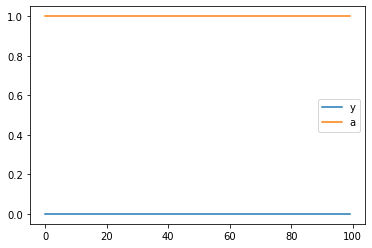

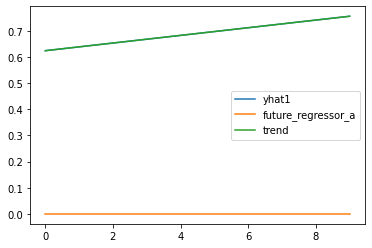

In [90]:
df[["y", "a"]].plot()
forecast2[["yhat1", "future_regressor_a", "trend"]].plot()

In [77]:
forecast1.head(2)

,ds,y,yhat1,yhat1 10.0%,yhat1 90.0%,trend,future_regressors_additive,future_regressor_a
0,2020-01-01,0,0.427,-0.468513,0.940342,-0.003152,0.430152,0.430152
1,2020-01-02,0,0.427,-0.468513,0.940342,-0.003152,0.430152,0.430152


In [94]:
m

In [156]:
import pandas as pd

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/global_local_modeling.ipynb)


# Global Local Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

When many time series share only "some behaviour" we will need a **global local model**. In the following notebook we will see an example of time series sharing behaviour/weights on all the components except from the trend and seasonality. Therefore, we will also build a global local model using data from the hourly load of the ERCOT region.

This notebook is an adaptation of `global_modeling.ipynb`.

First, we load the data:

In [4]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32


We extract the name of the regions which will be later used in the model creation.

In [5]:
regions = list(df_ercot)[1:]

In [6]:
list(set(df_ercot.ds))[0]

'2006-08-10 10:00:00'

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [7]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[["ds", col]].copy(deep=True)  # select column associated with region
    aux = aux.iloc[:26301, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
    aux["ID"] = col
    df_global = pd.concat((df_global, aux))

We will modify one time series trend and one time series seasonality

<AxesSubplot:>

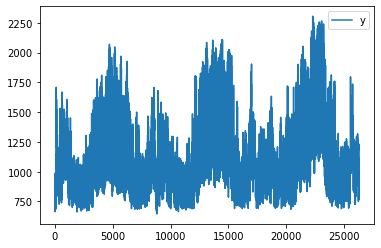

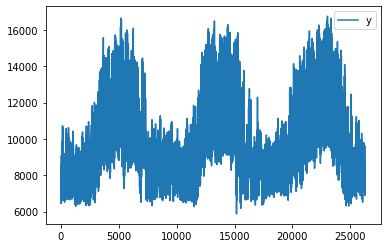

In [8]:
import numpy as np

# df_global["y"] = (
#     np.where(df_global["ID"] == "COAST", -df_global["y"], df_global["y"])
#     + 2 * df_global[df_global["ID"] == "COAST"].mean().y
# )
# df_global["y"] = np.where(df_global["ID"] == "NORTH", df_global["y"] + 0.1 * df_global.index, df_global["y"])

df_global[df_global["ID"] == "NORTH"].plot()
df_global[df_global["ID"] == "COAST"].plot()

In [9]:
df_global["regressor_id"] = (0.5 + np.random.rand(len(df_global))).astype(int)  # df_global["y"]
df_global["regressor_id1"] = (0.5 + np.random.rand(len(df_global))).astype(int)  # df_global["y"]

df_global["regressor_id2"] = (0.5 + np.random.rand(len(df_global))).astype(int)  # df_global["y"]
df_global["regressor_id3"] = df_global["y"]
df_global["regressor_id4"] = (0.1 + np.random.rand(len(df_global))).astype(int)  # df_global["y"]

In [10]:
df_local = df_global[df_global["ID"] == "COAST"]
df_local = df_local[["ds", "y"]]

In [11]:
df_local = df_global[df_global["ID"] == "COAST"]
df_local = df_local[["ds", "y"]]

In [12]:
# import neuralprophet.configure as configure

In [13]:
# from dataclasses import dataclass, field
# from typing import Callable, List, Optional
# from typing import OrderedDict as OrderedDictType
# from typing import Type, Union
# from collections import OrderedDict

# @dataclass
# class Regressor:
#     reg_lambda: Optional[float]
#     normalize: str
#     mode: str

# @dataclass
# class ConfigFutureRegressors:
#     model: str
#     regressors: OrderedDict = field(init=False)  # contains SeasonConfig objects

#     def __post_init__(self):
#         self.regressors = OrderedDictType[str, Regressor]

In [14]:
# ConfigFutureRegressors(
#             model='linear',
#         ) # Opti

In [15]:
# m.config_regressors

In [16]:
m = NeuralProphet()
df_train, df_test = m.split_df(df_global, valid_p=0.33, local_split=True)

## Global Modeling

**Remark:**
- Training a time series only with trend and seasonality components can result in poor performance. The following example is used just to show the new local modelling of multiple time series functionallity.


### DIFFERENT SEASONALITY MODELLING

In [31]:
m = NeuralProphet(
    quantiles=[0.2, 0.6],
    trend_global_local="global",
    season_global_local="global",
    #     weekly_seasonality=False,
    #     yearly_seasonality=False,
    #     daily_seasonality=False,
    yearly_seasonality_glocal_mode="global",
    changepoints_range=0.8,
    #     n_lags=2,
    epochs=1,
    trend_reg=1,
    future_regressors_model="shared_neural_nets",
    future_regressors_d_hidden=10,
    future_regressors_num_hidden_layers=3,
    #     quantiles=[0.1,0.9]
    #     drop_missing=True,
    #     future_regressors_model="neural_nets",
)

In [45]:
m.model.future_regressors.num_hidden_layers_regressors

3

In [32]:
m = m.add_future_regressor(name="regressor_id", mode="additive")
m = m.add_future_regressor(name="regressor_id1", mode="additive")

m = m.add_future_regressor(name="regressor_id2", mode="multiplicative")
m = m.add_future_regressor(name="regressor_id3", mode="multiplicative")

m = m.add_future_regressor(name="regressor_id4", mode="multiplicative")

In [33]:
m.config_trend

Trend(growth='linear', changepoints=None, n_changepoints=10, changepoints_range=0.8, trend_reg=0.001, trend_reg_threshold=None, trend_global_local='global', glocal_trend_reg=False)

In [34]:
m.config_regressors

ConfigFutureRegressors(model='shared_neural_nets', d_hidden=10, num_hidden_layers=3, regressors=OrderedDict([('regressor_id', Regressor(reg_lambda=None, normalize='auto', mode='additive')), ('regressor_id1', Regressor(reg_lambda=None, normalize='auto', mode='additive')), ('regressor_id2', Regressor(reg_lambda=None, normalize='auto', mode='multiplicative')), ('regressor_id3', Regressor(reg_lambda=None, normalize='auto', mode='multiplicative')), ('regressor_id4', Regressor(reg_lambda=None, normalize='auto', mode='multiplicative'))]))

In [35]:
metrics = m.fit(df_train, freq="H")

Finding best initial lr:   0%|          | 0/278 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [36]:
metrics

,MAE,RMSE,Loss,RegLoss,epoch
0,0.156987,0.198462,0.087566,0.0,0


In [37]:
df_global.drop_duplicates(subset=["ds", "ID"])

,ds,y,ID,regressor_id,regressor_id1,regressor_id2,regressor_id3,regressor_id4
0,2004-01-01 01:00:00,7225.09,COAST,1,0,0,7225.09,0
1,2004-01-01 02:00:00,6994.25,COAST,0,0,1,6994.25,0
2,2004-01-01 03:00:00,6717.42,COAST,1,1,1,6717.42,0
3,2004-01-01 04:00:00,6554.27,COAST,1,1,1,6554.27,0
4,2004-01-01 05:00:00,6511.19,COAST,0,1,0,6511.19,1
...,...,...,...,...,...,...,...,...
26296,2006-12-31 20:00:00,817.88,WEST,0,0,0,817.88,0
26297,2006-12-31 21:00:00,875.25,WEST,0,1,0,875.25,0
26298,2006-12-31 22:00:00,976.14,WEST,0,0,1,976.14,0
26299,2006-12-31 23:00:00,971.85,WEST,0,0,1,971.85,0


In [38]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True, regressors_df=df_global)
forecast = m.predict(future)

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

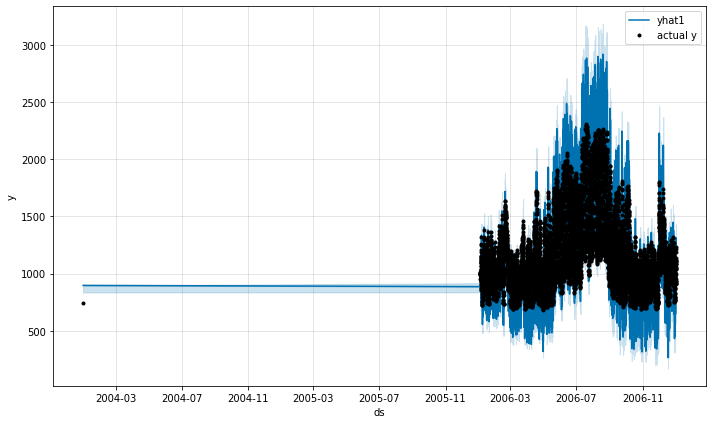

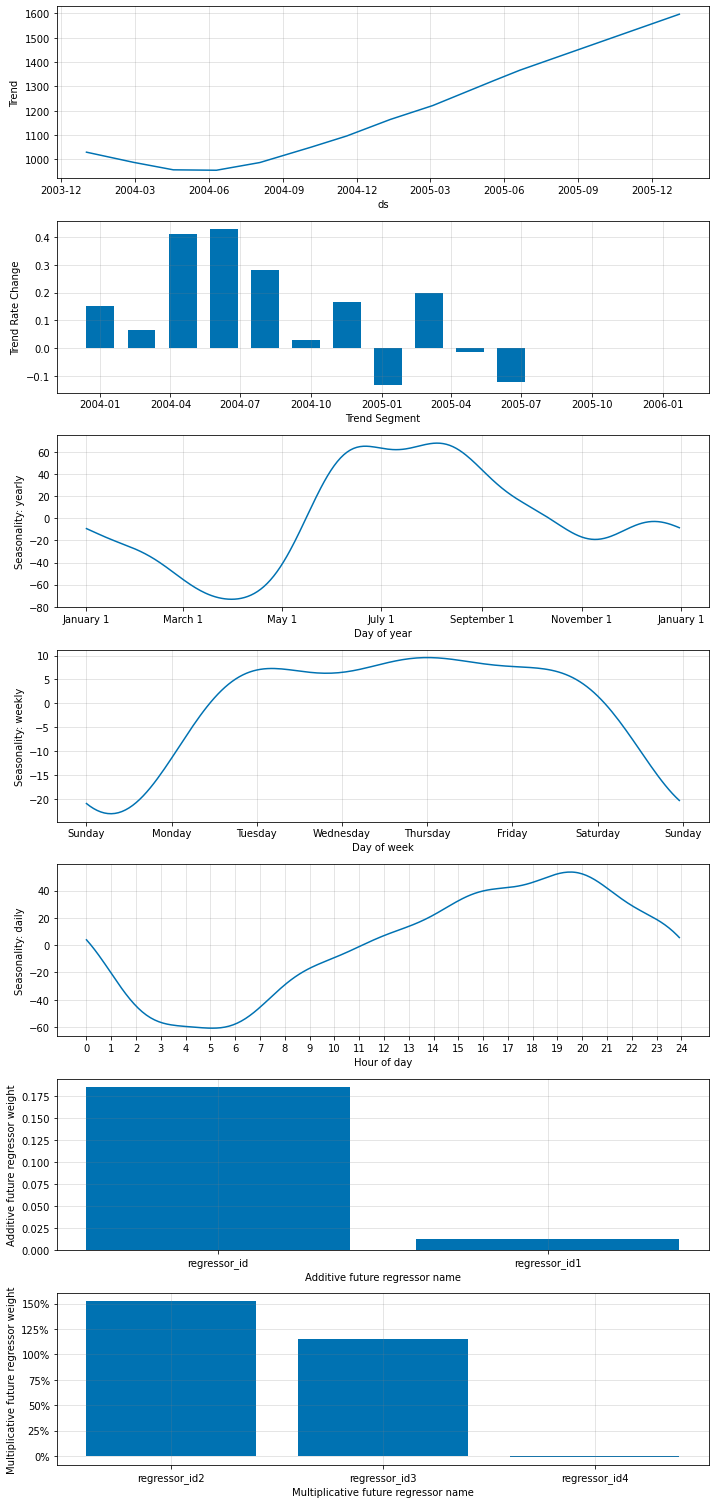

In [39]:
fig = m.plot(forecast[forecast["ID"] == "NORTH"])
fig_param = m.plot_parameters(df_name="NORTH")

In [40]:
m.local_vis_3["components"]

['trend', 'trend_rate_change', 'seasonality', 'future_regressors']

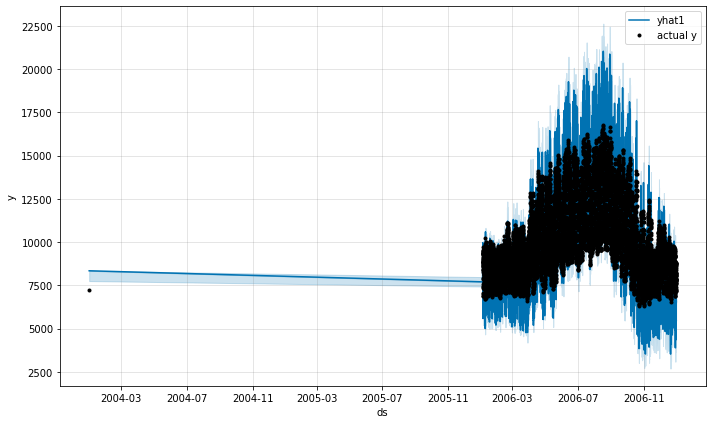

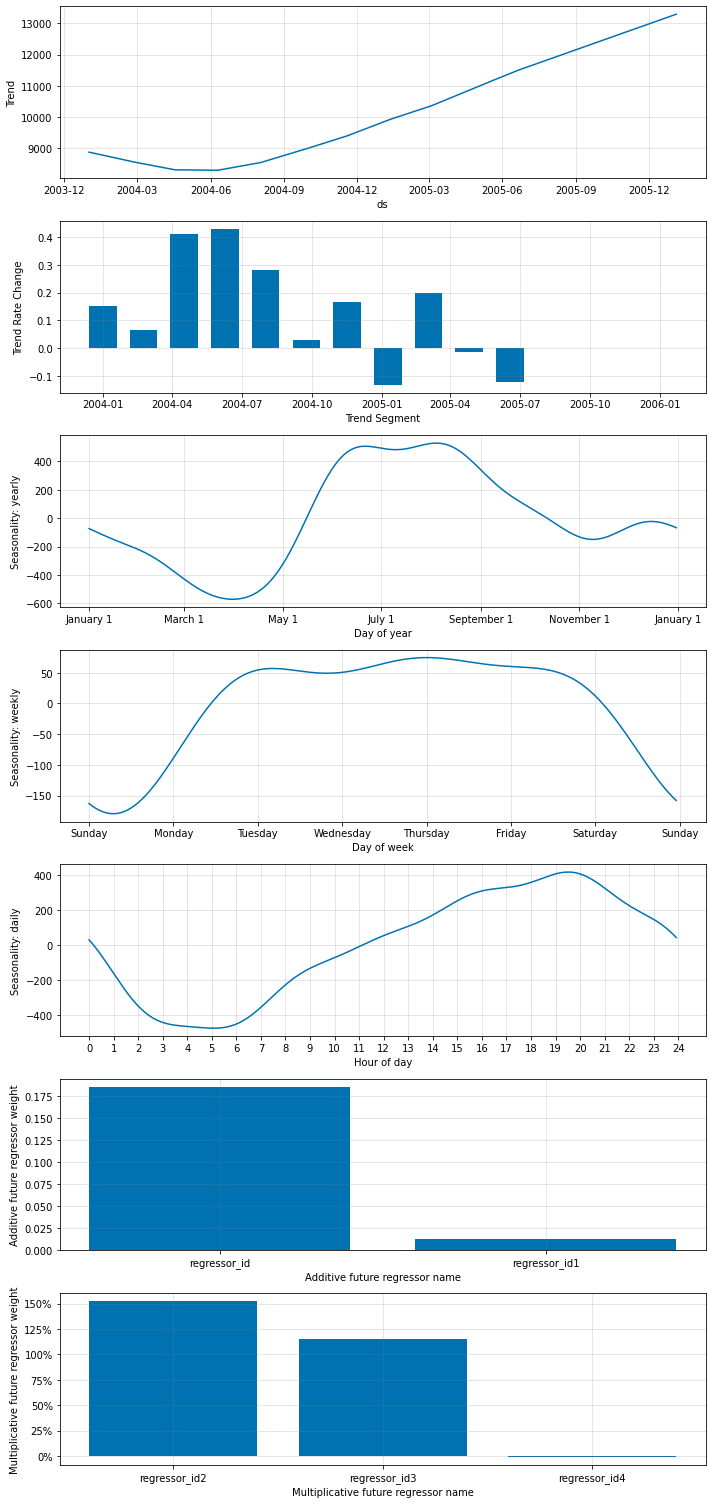

In [41]:
fig = m.plot(forecast[forecast["ID"] == "COAST"])
fig_param = m.plot_parameters(df_name="COAST")

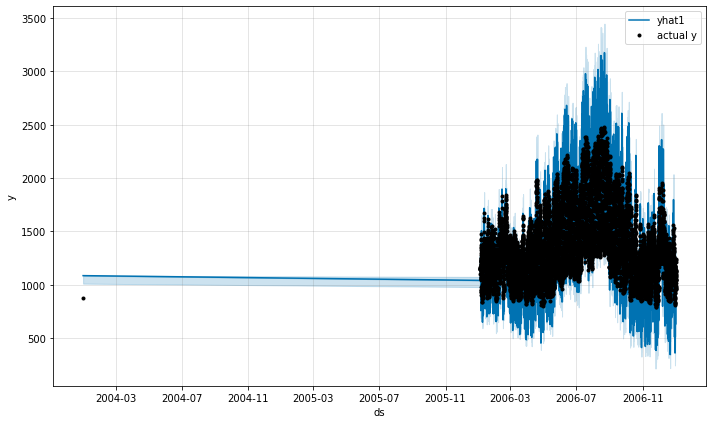

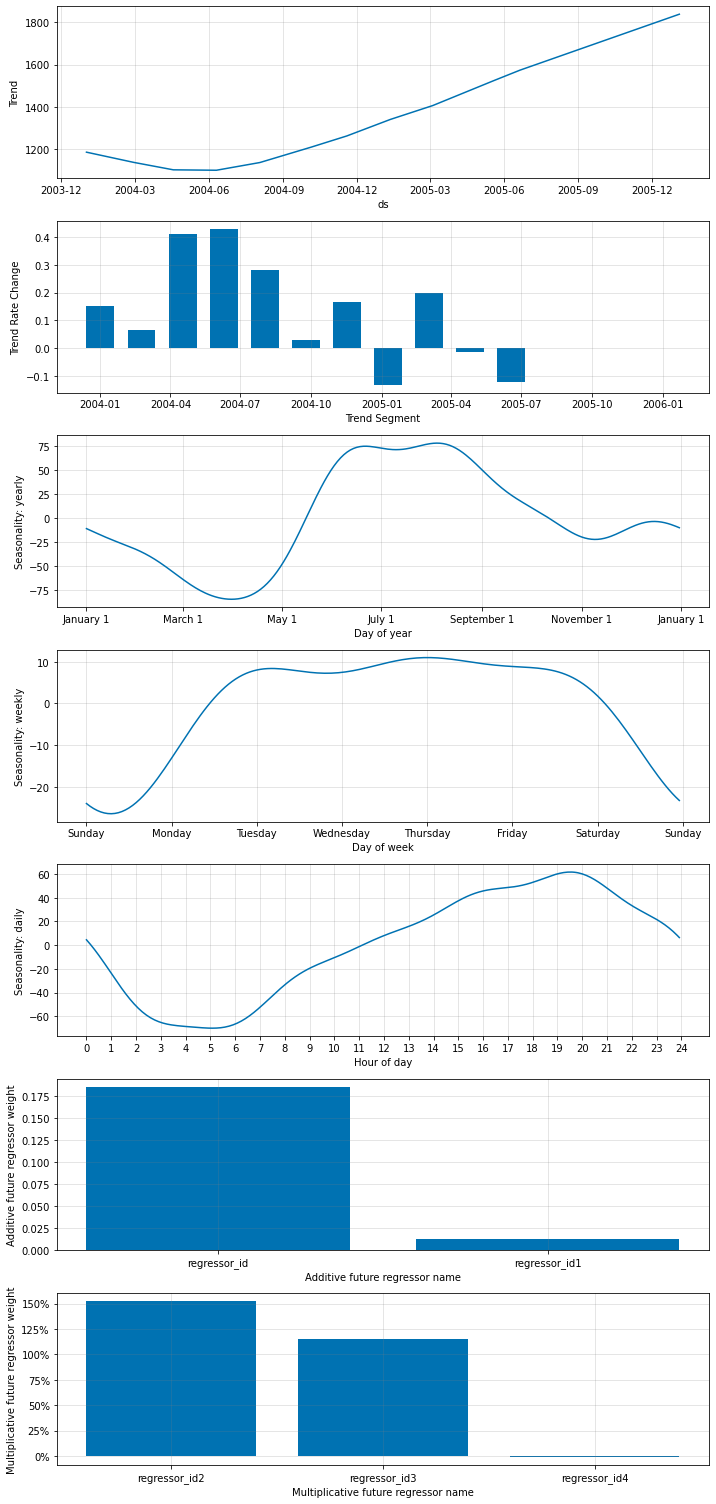

In [42]:
fig = m.plot(forecast[forecast["ID"] == "EAST"])
fig_param = m.plot_parameters(df_name="EAST")

In [43]:
test_metrics_global = m.test(df_test)
test_metrics_global

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.032875239849090576    │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,Loss_test,RegLoss_test
0,0.032875,0.0


# Architecture

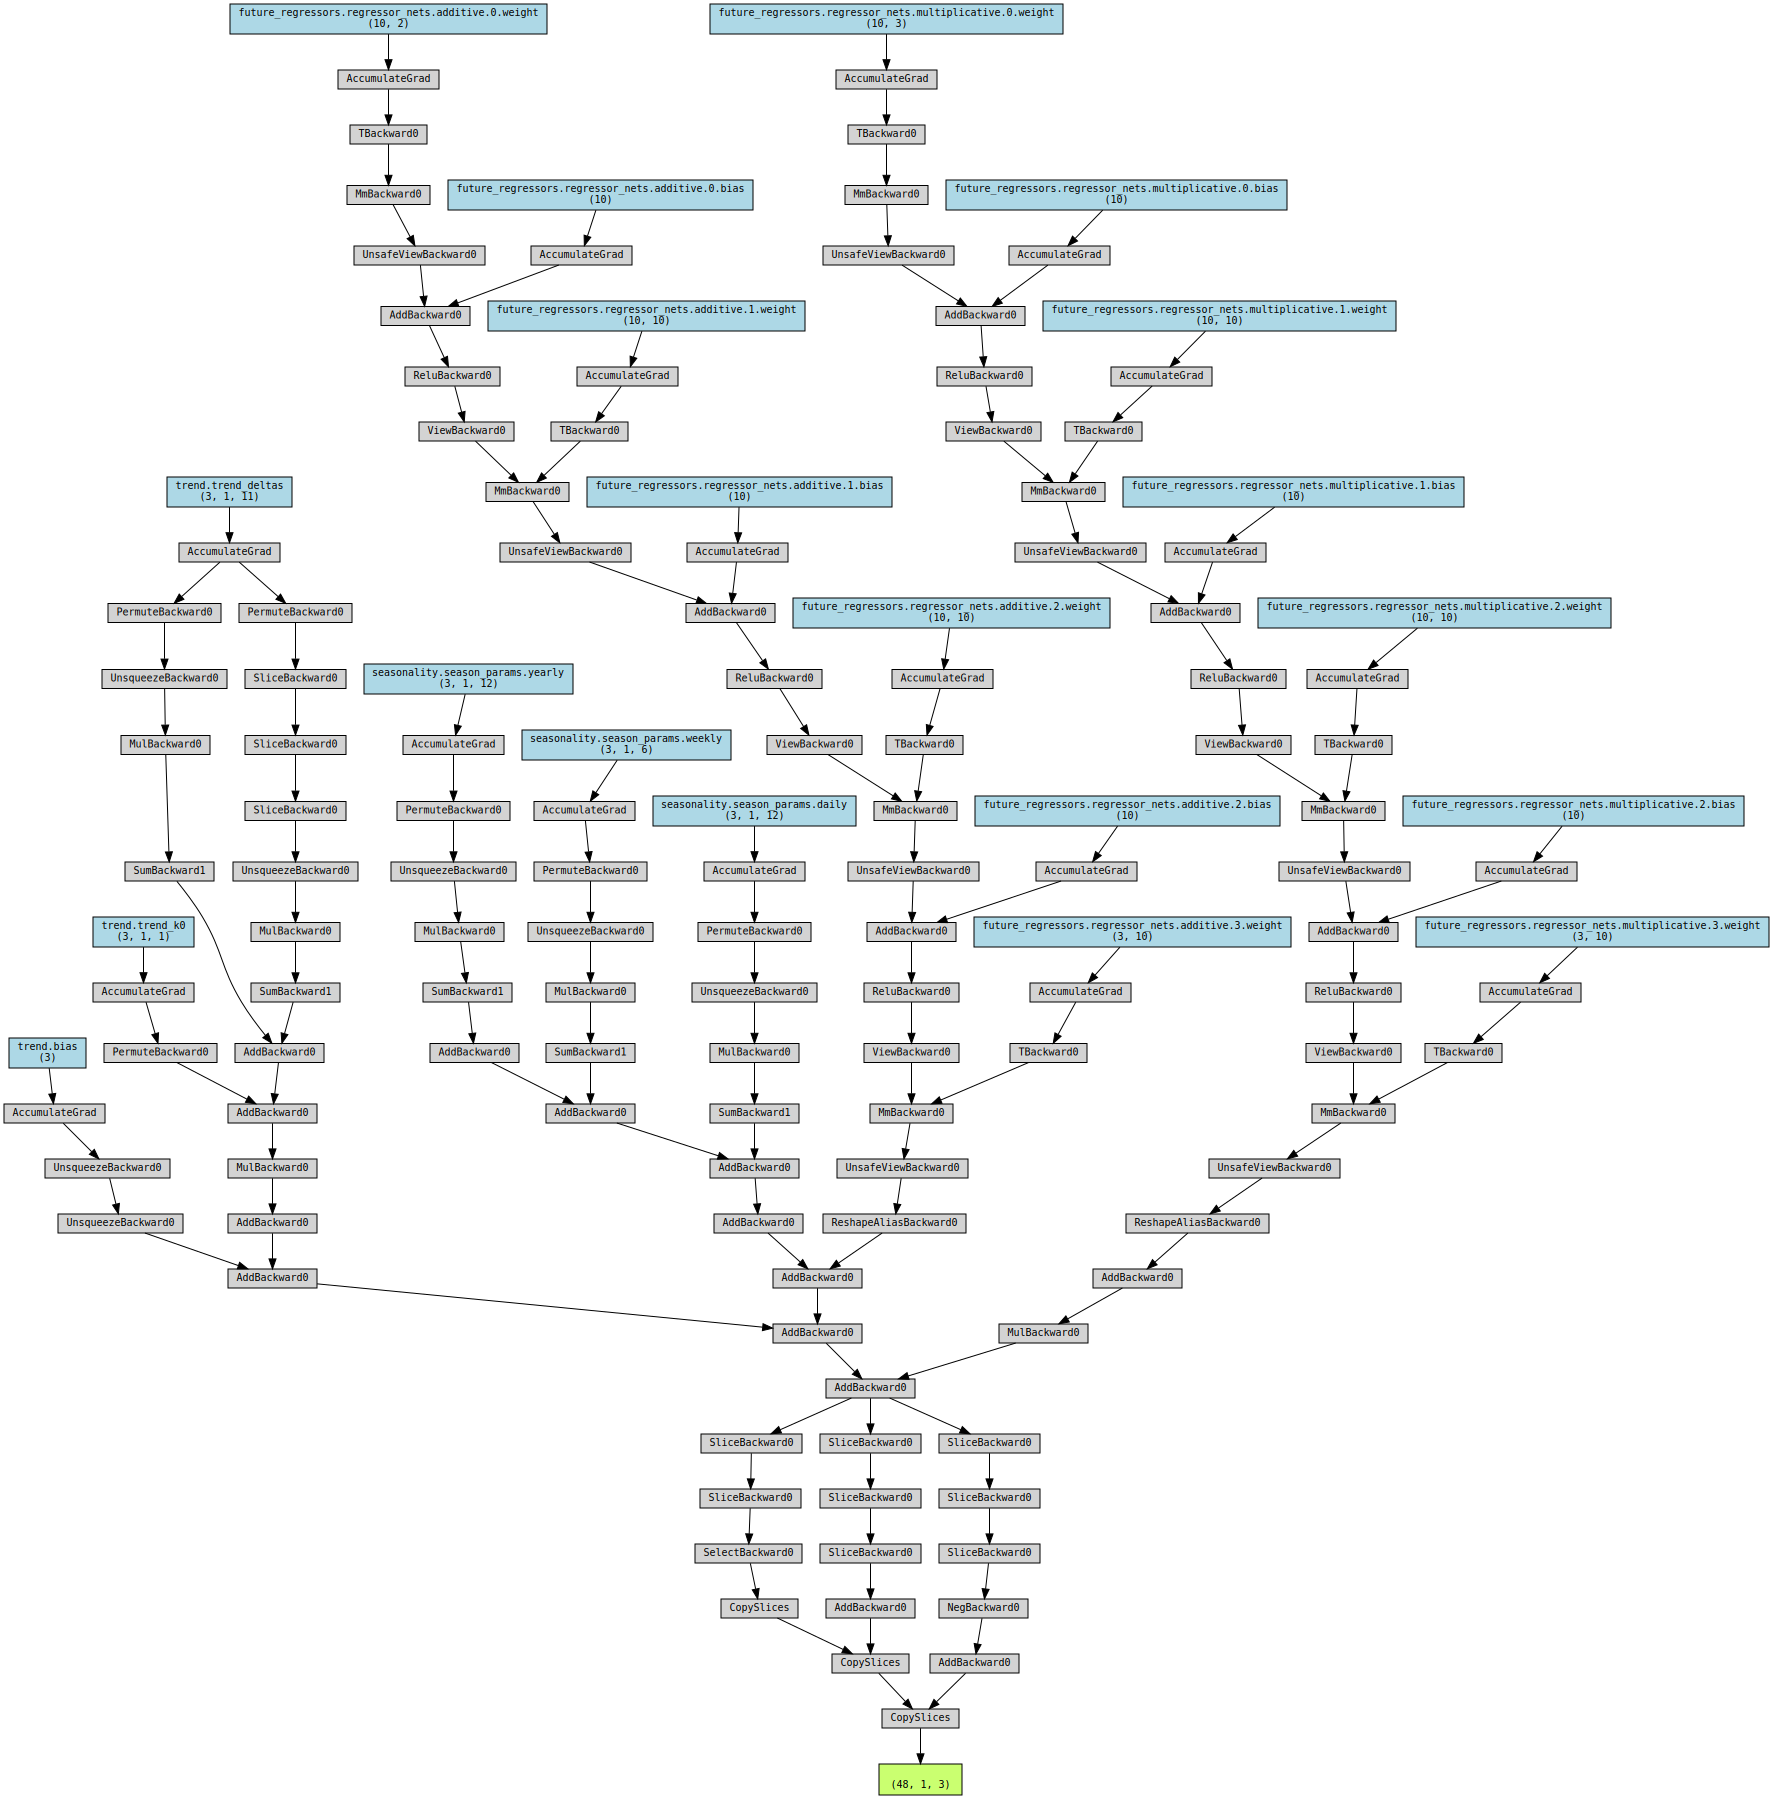

In [46]:
fig = make_dot(m.model.train_epoch_prediction, params=dict(m.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)